In [1]:
import glob
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = '/kaggle/input/utkface-new/UTKFace'

In [3]:
img_path = glob.glob(os.path.join(path,'*.jpg'))

In [4]:
img_path[:5]

['/kaggle/input/utkface-new/UTKFace/26_0_2_20170104023102422.jpg.chip.jpg',
 '/kaggle/input/utkface-new/UTKFace/22_1_1_20170112233644761.jpg.chip.jpg',
 '/kaggle/input/utkface-new/UTKFace/21_1_3_20170105003215901.jpg.chip.jpg',
 '/kaggle/input/utkface-new/UTKFace/28_0_0_20170117180555824.jpg.chip.jpg',
 '/kaggle/input/utkface-new/UTKFace/17_1_4_20170103222931966.jpg.chip.jpg']

In [4]:
age_label = []
gender_label = []

In [5]:
for img in img_path:
    imgg = img.split('_')
    gender_label.append(imgg[1])
    age = imgg[0].split('/')
    age_label.append(age[-1])


In [6]:
df = pd.DataFrame({'Img_Path':img_path,'Gender':gender_label,'Age':age_label})

In [7]:
df.head()

,Img_Path,Gender,Age
0,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...,0,26
1,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...,1,22
2,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...,1,21
3,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...,0,28
4,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...,1,17


In [31]:
df['Gender'].value_counts()

Gender
0    12391
1    11317
Name: count, dtype: int64

In [8]:
df['Img_Path'][1]

'/kaggle/input/utkface-new/UTKFace/22_1_1_20170112233644761.jpg.chip.jpg'

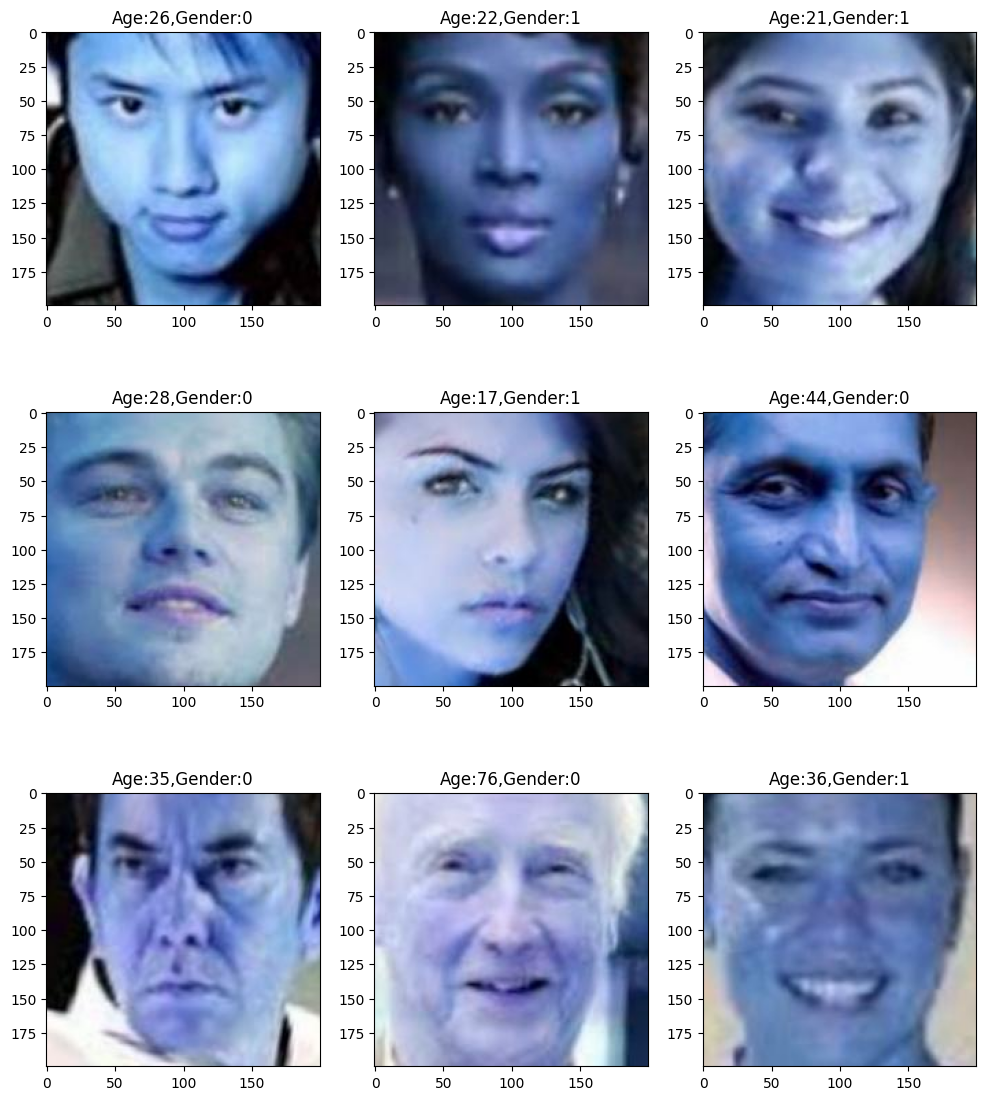

In [9]:
plt.figure(figsize=(12,14))
for i in range(9):
    plt.subplot(3,3,i+1)
    img = cv2.imread(df['Img_Path'][i])
    age = df['Age'][i]
    gender = df['Gender'][i]
    plt.title(f'Age:{age},Gender:{gender}')
    plt.imshow(img)

In [10]:
from keras.layers import Dense,Dropout,BatchNormalization,GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split

In [11]:
img_path = df['Img_Path']
age = df['Age']
gender = df['Gender']

In [12]:
def preprocess_img(path,target_size=(128,128)):
    img = load_img(path,target_size = target_size)
    img = img_to_array(img)
    img/=255
    return img

In [13]:
img_path = [preprocess_img(img) for img in img_path]
age = np.array(age)
gender = np.array(gender)

In [14]:
img_path = np.array(img_path)

In [15]:
base_model = ResNet50(weights='imagenet',include_top=False,input_shape=(128,128,3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
X_train,X_test,gender_train,gender_test,age_train,age_test = train_test_split(img_path,gender,age,test_size=0.2)

In [17]:
for layer in base_model.layers:
    layer.trainable = False

In [18]:
import numpy as np

gender_train = np.asarray(gender_train, dtype=np.float32)
age_train = np.asarray(age_train, dtype=np.float32)
gender_test = np.asarray(gender_test, dtype=np.float32)
age_test = np.asarray(age_test, dtype=np.float32)


In [19]:
gender_train

array([1., 1., 1., ..., 0., 1., 1.], dtype=float32)

In [32]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.3)(x)

gender_output = Dense(1,activation='sigmoid',name='gender_output')(x)
age_output = Dense(1,activation='linear',name='age_output')(x)

model = Model(inputs = base_model.input, outputs = [gender_output,age_output])

model.compile(optimizer='adam',
             loss = {'gender_output':'binary_crossentropy','age_output':'mean_absolute_error'},
             metrics = {'gender_output':'accuracy','age_output':'mae'})
#model.summary()

In [33]:
model.fit(X_train,{'gender_output':gender_train,'age_output':age_train},
          validation_data=(X_test,{'gender_output':gender_test,'age_output':age_test}), epochs=20,batch_size=32)

Epoch 1/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 49s 61ms/step - age_output_mae: 17.4771 - gender_output_accuracy: 0.5904 - loss: 18.2795 - val_age_output_mae: 13.0686 - val_gender_output_accuracy: 0.7296 - val_loss: 13.6332
Epoch 2/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - age_output_mae: 13.1001 - gender_output_accuracy: 0.6886 - loss: 13.6936 - val_age_output_mae: 12.0569 - val_gender_output_accuracy: 0.7450 - val_loss: 12.5899
Epoch 3/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - age_output_mae: 12.6199 - gender_output_accuracy: 0.7153 - loss: 13.1845 - val_age_output_mae: 11.7201 - val_gender_output_accuracy: 0.7303 - val_loss: 12.2541
Epoch 4/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - age_output_mae: 12.3699 - gender_output_accuracy: 0.7171 - loss: 12.9270 - val_age_output_mae: 11.4293 - val_gender_output_accuracy: 0.7528 - val_loss: 11.9419
Epoch 5/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - age_output_mae: 12.1071 - gender_output_accuracy: 0.7341 - loss: 12.6437 - val_a

In [22]:
y_pred = model.predict(X_test)

149/149 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step


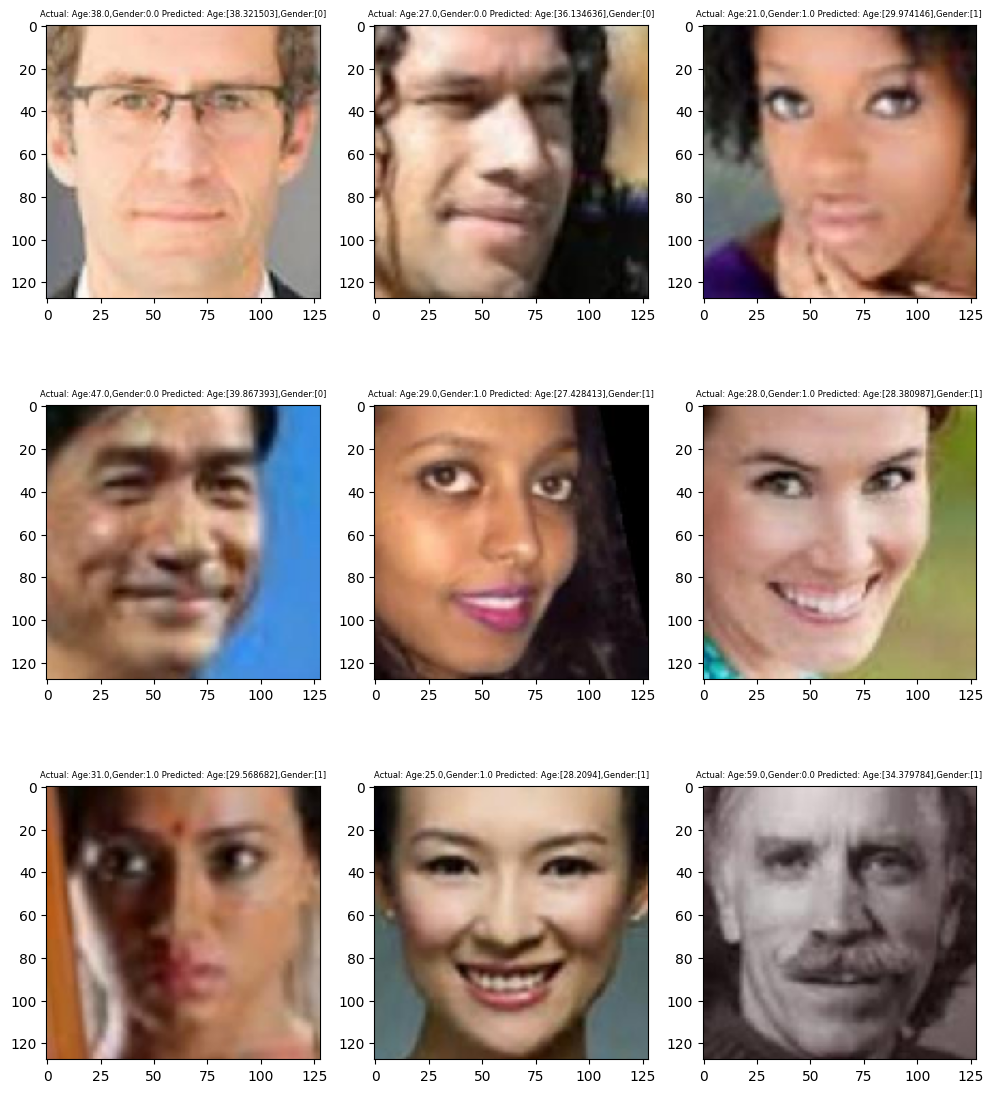

In [50]:
plt.figure(figsize=(12,14))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[i])
    age = age_test[i]
    gender = gender_test[i]
    gender_2 = y_pred[0][i]
    x = [1 if gender_2>0.5 else 0]
    age_2 = y_pred[1][i]
    plt.title(f'Actual: Age:{age},Gender:{gender} Predicted: Age:{age_2},Gender:{x}',fontsize=6)